<h1>Example: Transverse Field Ising Model</h1>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:

###
### General imports
###

#import time

import numpy              as np
import numpy.linalg       as la
import scipy.integrate    as spi
import matplotlib.pyplot  as plt

###
### Operator simulation & Hamiltonian
### preperation imports
###

from pyLIQTR.sim_methods.simqsp             import SimQSP
import pyLIQTR.sim_methods.quantum_ops        as     qops    


###
### Imports to support the pyQSP Gate-Based simulation
###

import cirq

from pyLIQTR.QSP          import gen_qsp   as   qspFuncs
from pyLIQTR.QSP          import QSP       as   pQSP
from pyLIQTR.QSP.gen_qsp  import QSP_Simulator

from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers import get_state_vector
from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once 

from cirq.contrib.svg import SVGCircuit


<h2><u>Transverse-Field Ising Model</u></h2>

The previous tutorial demonstrated how we can use pyLIQTR to generate the 1-$d$ Tranverse-Field Ising Hamiltonian in matrix form. We also saw how to generate a representation of each term as a Pauli string.  To recapitulate, this Hamiltonian takes the form:

\begin{equation}
H =  \sum_{j=1}^{N-1} \left[ J^x_j (X_j \otimes X_{j+1}) + J^y_j  (Y_j \otimes Y_{j+1}) + 
J^z_j (Z_j  \otimes  Z_{j+1}) \right] + 
\sum_{j=1}^N \left[ h^{x}_j X_j + h^{y}_j Y_j +  h^{z}_j Z_j \right]
\end{equation}

In writing this, we have used $J^{(x,y,z)}_j$ to designate spin-spin couplings and write $h^{(x,y,z)_j}$ for the local fields (note that this model is often written with only a $Z$ field).  We will demonstrate how to us `pyLIQTR` in order to simulate the model via a quantum circuit.

<b>Note: </b> <i>The cell below prepares the Hamiltonain matrix by invoking `ham_from_pauli_tuples`. The size and cost of this will grow exponentially with $N$.  Be aware when increasing $N$ for comparative purposes.</i>

In [2]:
N    =   4;        J_z  =   1.0;          h_x  =  -1.0
tuples,types,coeffs = qops.params_heisenberg_1d(N,J_z=J_z,h_x=h_x,periodic=False)
ham_strings = qops.ps_text_full_set(tuples,types,N,Coeffs=coeffs)
H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

<h3>Classical Simulation</h3>

Although our goal is to generate circuits for quantum simulation, it is helpful to have some classical reference values on hand as a sanity check.  To this end, we can use the Hamitonian matrix $H$ that was generated by `ham_from_pauli_tuples` to numerically integrate the TFIM following a field quench.  We begin by setting some initial parameters:

In [3]:
dt            =  0.05                            # Integration timestep, Decrease this 
                                                 #   if you'd like a finer grain simulation
tmax          =  16.0                            # Maximal timestep
sclf          =  1                               # Scale factor for timestep sampling
N_ts          =  int(np.ceil(tmax/dt))           # Total number of timesteps
timestep_vec  =  np.arange(0,tmax+dt,sclf*dt)    # Define array of timesteps


Next, we build up the initial wavefunction as a spin-up product state $\mid\psi_0\rangle = \bigotimes_{j=0}^{N-1} \mid \uparrow\rangle$ so that:

In [4]:

psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

psi0_vec = qops.vectorize_cvec(psi0)             # Vectorize the initial wavefunction



We can verify the local expectation value of $Z_j$ on each site of the lattice:


In [5]:

print(qops.measure_obs_site(psi0,qops.pz).real)


[1. 1. 1. 1.]


The derivative $\partial_t \mid\psi\rangle = -\imath H \mid \psi\rangle$ is given by the function `prop_wfn` in the `quantum_ops` module.  This allows us to use ODEPACK methods to integrate the wavefunction: 

In [6]:

traj_raw_wfn = spi.odeint(qops.prop_wfn,psi0_vec,timestep_vec,args=(H,),atol=1e-16)


There is also a method `parse_wfn_traj` which can evaluate a single qubit observable on every qubit for every timestep in the trajectory (or, alternatively, an N-qubit observable for every timestep).  We evaluate this for the spin-up projector `przp` $= (1 + Z)/2$:

In [7]:

traj_proc_wfn = qops.parse_wfn_traj(timestep_vec,traj_raw_wfn,qops.przp)

obs_reference = traj_proc_wfn[:,1:(N+1)].real

Finally, we plot the time evolution of our observable:

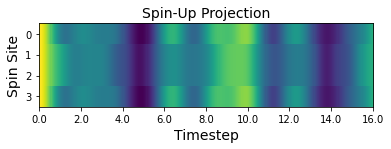

In [8]:

N_ticks = 8

aspect = 1/0.05

plt.imshow(np.transpose(obs_reference),
           cmap='viridis', interpolation='nearest', aspect=aspect)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)


plt.xticks(np.arange(0,N_ts+1,N_ts/N_ticks),labels=np.arange(0,tmax+dt,int(tmax/N_ticks)))
plt.show()


The mean spin projection at each timepoint should immediately look  familiar to anyone who has studied this model:

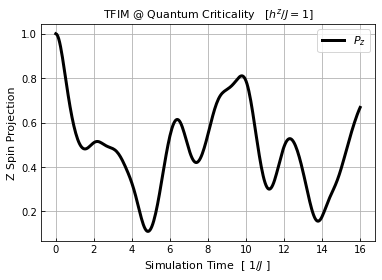

In [9]:

prpz_mean_data = np.mean(np.transpose(obs_reference),0)
xvec           = np.linspace(0,16,num=len(prpz_mean_data))

plt.plot(xvec,prpz_mean_data,linewidth=3,color='k')
plt.legend(["$P_z$","QSP"],fontsize=11)
plt.tick_params(axis='both',which='both',direction='in')
plt.xlabel('Simulation Time  [ $1/J$ ]',fontsize=11)
plt.ylabel('Z Spin Projection',fontsize=11)
plt.title('TFIM @ Quantum Criticality   $[h^z / J = 1]$',fontsize=11)
plt.grid()


<h3>QSP: Circuit Generation</h3>

Having convinced ourselves that QSP is giving a numerically sensible result in the previous tutorial, we can procede to construct practical circuits for quantum simulation.   Circuit generation is performed by the `pQSP` class from   `pyLIQTR` library.  Once again, we require an input set of tuples that contain Pauli strings for the target Hamiltonian and their corresponding coefficients.  We previously generated these using the `ps_text_full_set(...)` and will feed them into an internal representation of the target Hamiltonian generated from Pauli strings using the `pyH(...)` routine:

In [10]:

qsp_H       = pyH(ham_strings)

Which we can then pass as an argument to a separate set of angle generation routines (<b>NOTE: We continue to use this legacy implementation, though it will soon be deprecated in favor of the new more flexible and portable angle generation implementation </b>):

In [11]:

required_precision = 1e-2

#Old, deprecated
#angles, tolerances = qspFuncs.get_phis(qsp_H, simtime=dt, 
#                                       req_prec=required_precision);
angles, tolerances = qspFuncs.compute_hamiltonian_angles(qsp_H, simtime=dt, req_prec=required_precision, mode="legacy")



[13:38:11]  ~ minimum error (empirical): 2.724729659670389e-06
[13:38:11] 1 cached results with tau=0.35, m=8: prec=454
[13:38:11] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 2.72472965967039e-6


With the required phase angles and Hamiltonian in hand, we use the `QSP` class (imported here as `pQSP`) to construct the target circuit:

In [12]:

qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, 
                         target_size=qsp_H.problem_size)

qsp_circ      = qsp_generator.circuit()


The output `qsp_circ` is a standard `cirq` circuit.  we can print this to see a high-level organization of the QSP sequence:

In [13]:

qsp_circ
#SVGCircuit(qsp_circ)


0: ───────────────────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV────────────────────────
                              │                   │                   │                   │
1: ───────────────────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV────────────────────────
                              │                   │                   │                   │
2: ───────────────────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV────────────────────────
                              │                   │                   │                   │
3: ───────────────────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV────────────────────────
                              │                   │                   │                   │
ctl_q5: ──────R───X───────────SelectV───Reflect───SelectV───Reflect───SelectV───Reflect───SelectV────────────────X───R───
                              │         │         │         │         │         │         │
ctl_q6: ──────R───X───────────SelectV───Reflect───SelectV───Reflect───SelectV───Reflect───SelectV────────────────X───R───
                              │         │         │         │         │         │         │
ctl_q7: ──────R───X───────────SelectV───Reflect───SelectV───Reflect───SelectV───Reflect───SelectV────────────────X───R───
                              │         │         │         │         │         │         │
phs_q4: ──────R───Rx(0.04π)───SelectV───Reflect───SelectV───Reflect───SelectV───Reflect───SelectV───Rx(0.039π)───R───────
                              │         │         │         │         │         │         │
z_anc_q8: ────R───────────────SelectV───Reflect───SelectV───Reflect───SelectV───Reflect───SelectV───R────────────────────
                              │                   │                   │                   │
z_anc_q9: ────R───────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV───R────────────────────
                              │                   │                   │                   │
z_anc_q10: ───R───────────────SelectV─────────────SelectV─────────────SelectV─────────────SelectV───R────────────────────

Or decompose the circuit to see constituents of the `SelectV` and `Reflect` unitaries.  It is much easier to interpret the output when it is visualized using `SVGCircuit(...)`.

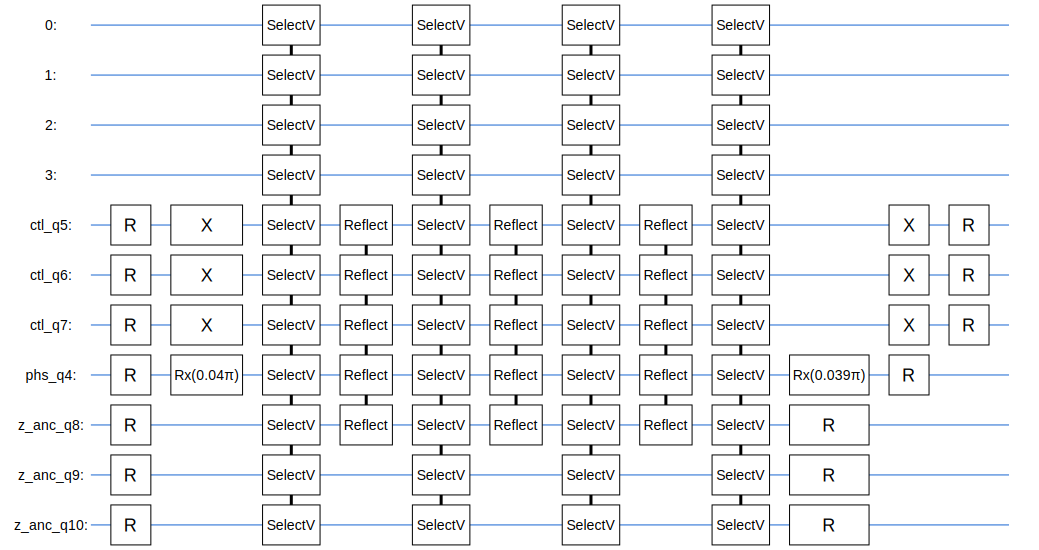

In [14]:

decomposed_once_circuit = (qsp_decompose_once(qsp_circ))
decomposed_circuit      = (qsp_decompose_once(decomposed_once_circuit))

SVGCircuit(qsp_circ)


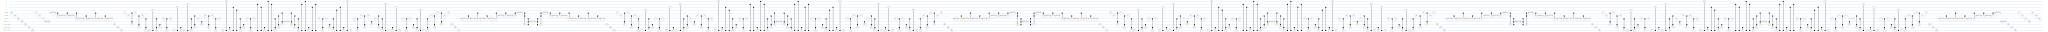

In [15]:
SVGCircuit(decomposed_circuit)

<h3>QSP: Circuit Simulation</h3>

We just saw how to construct a circuit for a single timestep.  This can be extended to generate its multi-timestep counterpart, which is straightforward to  simulate using `cirq`.  The first step is to generate angles for each timestep of interest.

<i>Note: We are not using the rescaled timesteps since we didn't rescale the Hamiltonian terms here.</i>

For the sake of numerical simplicity, we will look at times spanning between $0\cdot J^{-1}$ and  $5\cdot J^{-1}$.  For comparative purposes, the classically computed result on this domain is:

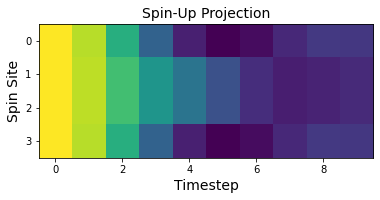

In [16]:

plt.imshow(np.transpose(obs_reference)[:,0:50:5],
           cmap='viridis', interpolation='nearest')
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)

plt.show()


To perform a simulation, we must generate phase angles across the target domain:

In [17]:
tmp = [qspFuncs.get_phis(qsp_H, simtime=t, req_prec=required_precision) for t in timestep_vec[0:50:5]]


tolerances   = [a[1] for a in tmp]
angles       = [a[0] for a in tmp]

/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/gen_qsp.py:112: UserWarning: 

    get_phis will be deprected by 'compute_hamiltonian_angles' in a future release

    The equivalent call is:
    	compute_hamiltonian_angles(<Hamiltonian>,<simtime>,<req_prec>,<mode>)
    		Supported modes: random (random angles),legacy("old" generation)
    		Upcoming modes: expander (a more powerful, faster, flexible angle calculation tool)
    

    
  warnings.warn(msgblk)
/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
/Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)
[13:38:24]  ~ minimum error (empirical): 0.00014394996542883284
[13:38:24] 1 cached results with tau=1.75, m=12: prec=4

Req eps = 0.01	Act eps = 0
Req eps = 0.01	Act eps = 0.000143949965428833
Req eps = 0.01	Act eps = 1.88348753070019e-5


[13:38:24]  ~ minimum error (empirical): 5.771744759171546e-05
[13:38:24] 1 cached results with tau=5.25, m=24: prec=312
[13:38:24] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache
[13:38:24]  ~ minimum error (empirical): 0.00010910059322076398
[13:38:24] 1 cached results with tau=7.0, m=28: prec=314
[13:38:24] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache
[13:38:24]  ~ minimum error (empirical): 0.00016310122879854922
[13:38:24] 1 cached results with tau=8.75, m=32: prec=316
[13:38:24] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 5.77174475917155e-5
Req eps = 0.01	Act eps = 0.000109100593220764
Req eps = 0.01	Act eps = 0.000163101228798549


[13:38:24]  ~ minimum error (empirical): 1.5715799847768894e-05
[13:38:24] 1 cached results with tau=10.5, m=40: prec=320
[13:38:24] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache
[13:38:25]  ~ minimum error (empirical): 2.173595151420572e-05
[13:38:25] 1 cached results with tau=12.25, m=44: prec=322
[13:38:25] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache
[13:38:25]  ~ minimum error (empirical): 2.7637807027830258e-05
[13:38:25] 1 cached results with tau=14.0, m=48: prec=324
[13:38:25] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 1.57157998477689e-5
Req eps = 0.01	Act eps = 2.17359515142057e-5
Req eps = 0.01	Act eps = 2.76378070278303e-5


[13:38:25]  ~ minimum error (empirical): 3.308830098119543e-05
[13:38:25] 1 cached results with tau=15.75, m=52: prec=326
[13:38:25] retrieved cached angles from /Users/ar26431/opt/anaconda3/envs/qalgo/lib/python3.10/site-packages/pyLIQTR/QSP/.qspangles.cache


Req eps = 0.01	Act eps = 3.30883009811954e-5


Since the Heisenberg Hamiltonian is "native" in the computational basis, we can draw a direct correspondence between $Z$ spin eigenstates and the computational basis so that $|0\rangle \equiv |\uparrow\rangle$ and $|1\rangle \equiv |\downarrow\rangle$.  Thus, if we want an initial spin population that is polarized along the $+Z$ direction - consistent with the initial product state $|\psi(0)\rangle = \otimes_{i=1}^4 |\uparrow_i\rangle$ of our reference calculation - we must flip the data qubits before applying the QSP sequence.  We can do this by appending an initial circuit layer that applies a Pauli $X$ gate to these qubits. 

The initial state of the circuit is constructed using a straightforward procedure:

In [18]:
occ_state = np.ones(N)
#occ_state[1] = 1.0

qsp_generator = pQSP.QSP(phis=angles[1], hamiltonian=qsp_H, target_size=qsp_H.problem_size)

initial_state_circuit = cirq.Circuit()

# Set qubit states to desired initial conditions
for idx,state in enumerate(occ_state[::-1]):
    if state == 1:
        initial_state_circuit.append(cirq.X.on(qsp_generator.target[idx]))
    else:
        initial_state_circuit.append(cirq.I.on(qsp_generator.target[idx]))
        

We are now ready to simulate our circuit. The `QSP_Simulator` class automates the process of performing circuit-level simulations for different timesteps.  The underlying components (times, angles, Hamiltonian, initial state) are passed to its constructor, and the simulation itself is invoked using the `doSim(...)` method.

As a note, the `QSP_Simulator` is more-or-less a wrapper around the state simulator provided by cirq, where the `do_sim()` call essentially performs the following:
```
    circuit = initial_state_circuit + pQSP.QSP(<angles>, <hamiltonian>, <N>).circuit()
    return cirq.Simulator().simulate(circuit).final_state_vector
```


In [19]:

qsp_sim = QSP_Simulator(
    timestep_vec = timestep_vec,
    angles       = angles,
    init_state   = initial_state_circuit,
    qsp_H        = qsp_H)

sim_results = qsp_sim.do_sim()



We can calculate observables from the output by generating the state vector for each timestep and using the `measure_obs_site` routine that first appeared earlier:

In [20]:
def measure_obs_cirq(state,obs=qops.przp):
    state = get_state_vector(state,lsb_first=False)
    exp = np.real(qops.measure_obs_site(state[::-1], obs))[-N:]
    return exp

obs_circuit = []
for rslt in sim_results:
    obs_circuit.append(measure_obs_cirq(rslt)) 

This output may be visualized in the usual manner:

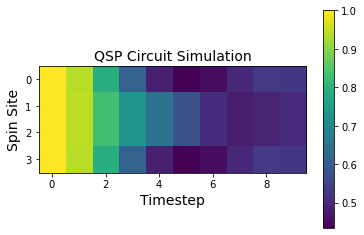

In [21]:
###
### Plot qubit population over time
###

#plt.figure(figsize=(5,5), dpi=300)
plt.imshow(np.transpose(np.real(obs_circuit)),cmap='viridis', interpolation='nearest')
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('QSP Circuit Simulation',fontsize=14)
plt.yticks([0,1,2,3],[0,1,2,3])

plt.colorbar()

plt.show()


#aspect=Ns/(3*N)

We can make a quantitative comparison, and satisfy ourselves that there is good agreement with the classical result:

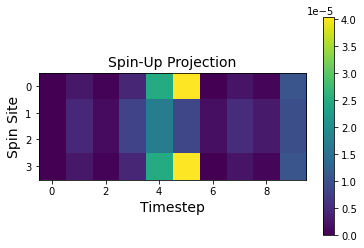

In [22]:

sim_diff = np.abs(obs_circuit - obs_reference[0:50:5,0:(N+1)])

#plt.figure(figsize=(5,5), dpi=300)
plt.imshow(np.transpose(sim_diff),cmap='viridis', interpolation='nearest')
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Spin Site',fontsize=14)
plt.title('Spin-Up Projection',fontsize=14)
plt.yticks([0,1,2,3],[0,1,2,3])
plt.colorbar()
#plt.xticks(np.arange(0,N_ts+1,N_ts/N_ticks),labels=np.arange(0,tmax+dt,int(tmax/N_ticks)))
plt.show()

#aspect=Ns/(3*N)